In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install covasim optuna
    !git clone https://github.com/mazzio97/EpidemicModelLearning.git
    sys.path.append('EpidemicModelLearning')
    sys.path.append('EpidemicModelLearning/notebooks')
    sys.path.append('EpidemicModelLearning/notebooks/util')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import covasim as cv
from util import data, calibration

sns.set_context('notebook')
sns.set_style('whitegrid')

pop_size = 450e3
pop_scale = 10
df = data.get_regional_data(scaling_factor=4.46e6/pop_size)

cols = set(df.columns) - {'date', 'new_tests'}
n_runs = 3
n_trials = 1000

sample_weight = calibration.get_sample_weights(df, 'proportional')
custom_estimator = calibration.get_custom_estimator('mse', sample_weight)

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


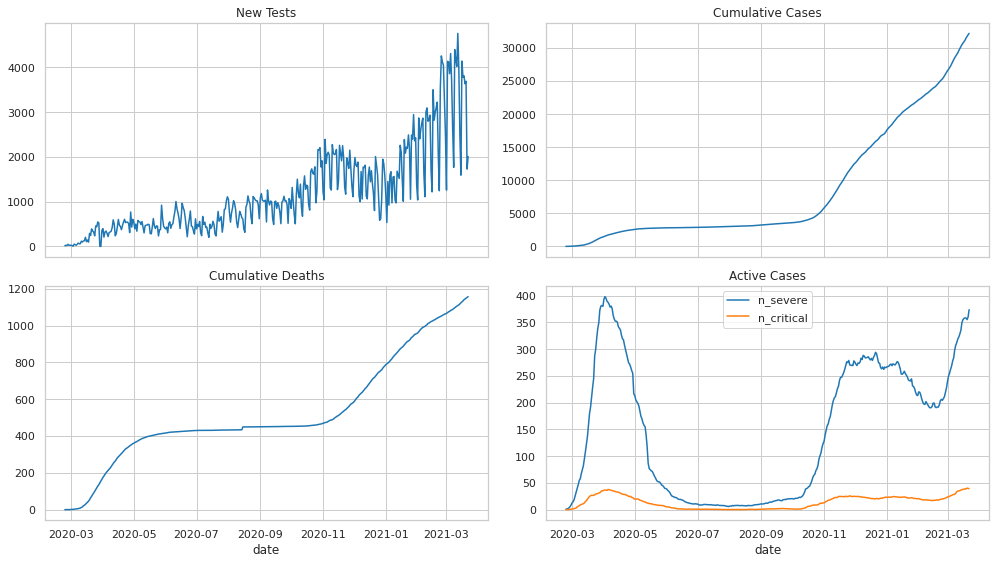

In [3]:
_, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0, 0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_diagnoses', ax=axes[0, 1]).set(title='Cumulative Cases', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1, 0]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_severe', label='n_severe', ax=axes[1, 1]).set(title='Active Cases')
sns.lineplot(data=df, x='date', y='n_critical', label='n_critical', ax=axes[1, 1]).set(ylabel='')

plt.tight_layout()

In [3]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 370.4 / 100e3,
    n_beds_icu=pop_size * 14.46 / 100e3,
    quar_period=14,
    verbose=0
)

In [ ]:
import optuna as op
from util.interventions import get_interventions
from util.calibration import fixed_param

constraint_orderings = [
    ('winter_beta', 'beta', 'summer_beta'),
    ('winter_symp', 'rel_symp_prob', 'summer_symp'),
    ('winter_sev', 'rel_severe_prob', 'summer_sev'),
    ('winter_crit', 'rel_crit_prob', 'summer_crit'),
    ('winter_death', 'rel_death_prob', 'summer_death'),
    ('yellow_contacts', 'orange_contacts'),
    ('white_imp', 'yellow_imp', 'orange_imp')
]

def objective(trial):
    # define learnable parameters
    initial_params = dict(
        pop_infected=trial.suggest_int('init_pop_infected', pop_size // 1e4, pop_size // 1e2, step=5),
        n_imports=trial.suggest_float('init_n_imports', 5.0, 20.0, step=1e-1),
        rel_symp_prob=trial.suggest_float('init_rel_symp_prob', 0.5, 5.0, log=True),
        rel_severe_prob=trial.suggest_float('init_rel_severe_prob', 0.5, 5.0, log=True),
        rel_crit_prob=trial.suggest_float('init_rel_crit_prob', 0.5, 5.0, log=True),
        rel_death_prob=trial.suggest_float('init_rel_death_prob', 0.5, 5.0, log=True),
        beta=trial.suggest_float('init_beta', 0.01, 0.04, step=None),
        **default_params
    )
    intervention_params = dict(
        trace_prob=trial.suggest_float('interv_trace_prob', 0.3, 0.9, step=1e-2),
        # CONTACT TRACING
        trace_time=trial.suggest_float('interv_trace_time', 1.0, 7.0, step=1e-1),
        work_contacts=trial.suggest_float('interv_work_contacts', 0.4, 1.0, step=1e-2),
        # SMART WORKING
        school_contacts=trial.suggest_float('interv_school_contacts', 0.2, 0.8, step=1e-2),
        # SCHOOLS CLOSED
        yellow_contacts=trial.suggest_float('interv_yellow_contacts', 0.4, 1.0, step=1e-2),
        # LOCKDOWN INTERVENTION
        orange_contacts=trial.suggest_float('interv_orange_contacts', 0.2, 0.9, step=1e-2),
        white_imp=trial.suggest_float('interv_white_imp', 5.0, 20.0, step=1e-1),
        # MASKS INTERVENTION
        winter_beta_change=trial.suggest_float('interv_winter_beta_change', 0.5, 1.0, step=1e-2),
        # IMPORTED CASES
        yellow_imp=trial.suggest_float('interv_yellow_imp', 3.0, 12.0, step=1e-1),
        orange_imp=trial.suggest_float('interv_orange_imp', 2.0, 8.0, step=1e-1),
        # VIRAL LOAD REDUCTION
        summer_beta=trial.suggest_float('interv_summer_beta', 0.002, 0.02, step=None),
        winter_beta=fixed_param(trial, 'interv_winter_beta', initial_params['beta']),
        summer_symp=trial.suggest_float('interv_summer_symp', 0.5, 5.0, log=True),
        winter_symp=fixed_param(trial, 'interv_winter_symp', initial_params['rel_symp_prob']),
        summer_sev=trial.suggest_float('interv_summer_sev', 0.5, 5.0, log=True),
        winter_sev=fixed_param(trial, 'interv_winter_sev', initial_params['rel_severe_prob']),
        summer_crit=trial.suggest_float('interv_summer_crit', 0.5, 5.0, log=True),
        winter_crit=fixed_param(trial, 'interv_winter_crit', initial_params['rel_crit_prob']),
        summer_death=trial.suggest_float('interv_summer_death', 0.5, 5.0, log=True),
        winter_death=fixed_param(trial, 'interv_winter_death', initial_params['rel_death_prob'])
    )
    # define and run simulations
    sim = cv.Sim(pars=initial_params, interventions=get_interventions(intervention_params), datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    # compute loss
    weights = {c: 1 for c in cols}
    mismatches = [s.compute_fit(keys=cols, weights=weights, estimator=custom_estimator).mismatch for s in msim.sims]
    violation = calibration.compute_violation({**initial_params, **intervention_params}, constraint_orderings)
    return sum(mismatches) / n_runs

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.

[I 2021-03-23 15:24:46,520] A new study created in memory with name: no-name-a90eaec2-65bb-4ad4-9caa-e4375a1c9db5
[I 2021-03-23 15:25:16,015] Trial 0 finished with value: 7.209036977914067 and parameters: {'init_pop_infected': 760, 'init_n_imports': 7.0, 'init_rel_symp_prob': 3.301697423148855, 'init_rel_severe_prob': 1.3028906720044284, 'init_rel_crit_prob': 1.3330728825054214, 'init_rel_death_prob': 2.319232361804656, 'init_beta': 0.01314976184081928, 'interv_trace_prob': 0.8799999999999999, 'interv_trace_time': 1.1, 'interv_work_contacts': 1.0, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.76, 'interv_orange_contacts': 0.52, 'interv_white_imp': 7.2, 'interv_winter_beta_change': 0.98, 'interv_yellow_imp': 4.7, 'inte

In [ ]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials]).sort_values('objective')
summary = results.head(n_trials // 20).describe().loc[['count', 'min', 'max']]
summary = summary.append(pd.Series({'objective': study.best_value, **study.best_params}, name='best'))
summary = summary.transpose().astype({'count': 'int'})
summary

In [4]:
results = [
    {'init_pop_infected': 1045, 'init_n_imports': 10.2, 'init_rel_symp_prob': 0.7735973353649707, 'init_rel_severe_prob': 0.9098347860944127, 'init_rel_crit_prob': 0.7168494019637344, 'init_rel_death_prob': 3.1795070073770098, 'init_beta': 0.017798403177744195, 'interv_trace_prob': 0.39, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.5700000000000001, 'interv_school_contacts': 0.62, 'interv_yellow_contacts': 1.0, 'interv_orange_contacts': 0.31, 'interv_white_imp': 5.0, 'interv_winter_beta_change': 0.5700000000000001, 'interv_yellow_imp': 6.6, 'interv_orange_imp': 7.0, 'interv_summer_beta': 0.003304809851918165, 'interv_winter_beta': 0.017798403177744195, 'interv_summer_symp': 0.6252366752254687, 'interv_winter_symp': 0.7735973353649707, 'interv_summer_sev': 0.7398341928525126, 'interv_winter_sev': 0.9098347860944127, 'interv_summer_crit': 3.5128392450109724, 'interv_winter_crit': 0.7168494019637344, 'interv_summer_death': 4.7839747689983, 'interv_winter_death': 3.1795070073770098},
    {'init_pop_infected': 730, 'init_n_imports': 10.5, 'init_rel_symp_prob': 1.0748532529268642, 'init_rel_severe_prob': 1.0814402568604076, 'init_rel_crit_prob': 0.8231552837378124, 'init_rel_death_prob': 2.4273374783978827, 'init_beta': 0.014861277439300536, 'interv_trace_prob': 0.54, 'interv_trace_time': 2.0, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.74, 'interv_yellow_contacts': 0.99, 'interv_orange_contacts': 0.32, 'interv_white_imp': 5.7, 'interv_winter_beta_change': 0.54, 'interv_yellow_imp': 7.1000000000000005, 'interv_orange_imp': 6.2, 'interv_summer_beta': 0.0035201779149679766, 'interv_winter_beta': 0.014861277439300536, 'interv_summer_symp': 0.687475221698325, 'interv_winter_symp': 1.0748532529268642, 'interv_summer_sev': 0.5274086103229174, 'interv_winter_sev': 1.0814402568604076, 'interv_summer_crit': 2.952674148274153, 'interv_winter_crit': 0.8231552837378124, 'interv_summer_death': 4.578069483686159, 'interv_winter_death': 2.4273374783978827},
    {'init_pop_infected': 855, 'init_n_imports': 10.5, 'init_rel_symp_prob': 1.7610752303643602, 'init_rel_severe_prob': 1.450530526434909, 'init_rel_crit_prob': 0.7229616832949068, 'init_rel_death_prob': 2.911831882491203, 'init_beta': 0.01293404070902779, 'interv_trace_prob': 0.59, 'interv_trace_time': 1.7000000000000002, 'interv_work_contacts': 0.64, 'interv_school_contacts': 0.36, 'interv_yellow_contacts': 0.99, 'interv_orange_contacts': 0.54, 'interv_white_imp': 5.3, 'interv_winter_beta_change': 0.56, 'interv_yellow_imp': 6.7, 'interv_orange_imp': 6.2, 'interv_summer_beta': 0.003925706958094842, 'interv_winter_beta': 0.01293404070902779, 'interv_summer_symp': 0.5227438010468396, 'interv_winter_symp': 1.7610752303643602, 'interv_summer_sev': 1.1453791401364817, 'interv_winter_sev': 1.450530526434909, 'interv_summer_crit': 4.197114226429401, 'interv_winter_crit': 0.7229616832949068, 'interv_summer_death': 4.358008241563926, 'interv_winter_death': 2.911831882491203}
]

{'init_pop_infected': 1045, 'init_n_imports': 10.2, 'init_rel_symp_prob': 0.7735973353649707, 'init_rel_severe_prob': 0.9098347860944127, 'init_rel_crit_prob': 0.7168494019637344, 'init_rel_death_prob': 3.1795070073770098, 'init_beta': 0.017798403177744195, 'interv_trace_prob': 0.39, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.5700000000000001, 'interv_school_contacts': 0.62, 'interv_yellow_contacts': 1.0, 'interv_orange_contacts': 0.31, 'interv_white_imp': 5.0, 'interv_winter_beta_change': 0.5700000000000001, 'interv_yellow_imp': 6.6, 'interv_orange_imp': 7.0, 'interv_summer_beta': 0.003304809851918165, 'interv_winter_beta': 0.017798403177744195, 'interv_summer_symp': 0.6252366752254687, 'interv_winter_symp': 0.7735973353649707, 'interv_summer_sev': 0.7398341928525126, 'interv_winter_sev': 0.9098347860944127, 'interv_summer_crit': 3.5128392450109724, 'interv_winter_crit': 0.7168494019637344, 'interv_summer_death': 4.7839747689983, 'interv_winter_death': 3.1795070073770098}


{

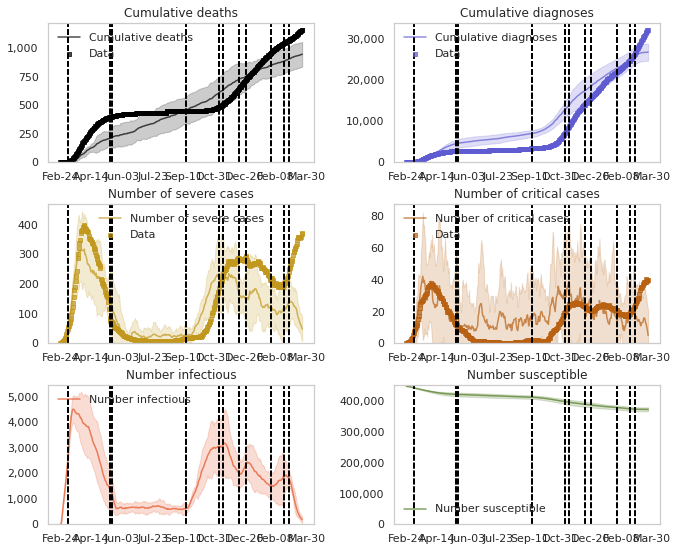

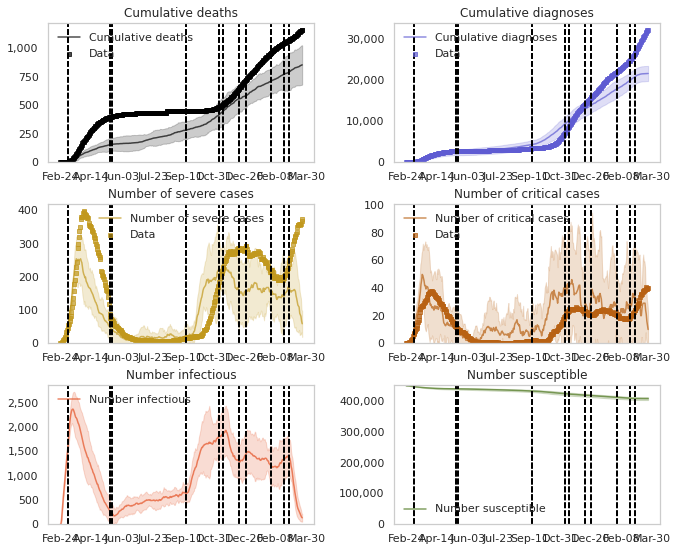

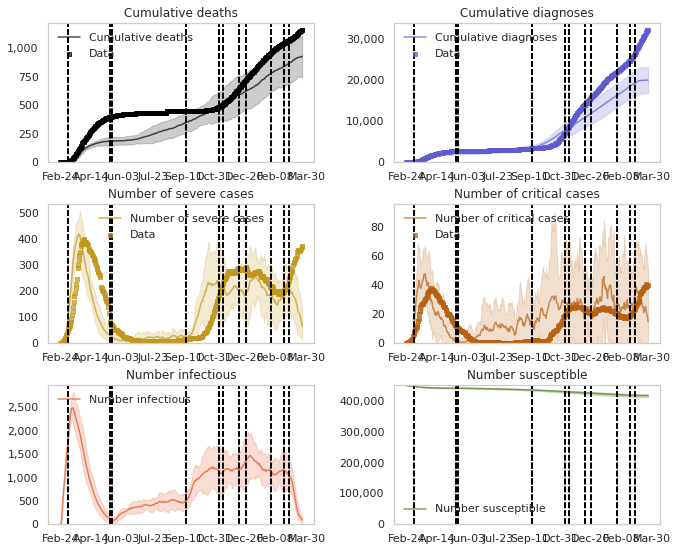

In [6]:
from util.interventions import get_interventions

for best_params in results:
  initial_params = {k[5:]: v for k, v in best_params.items() if k.startswith('init_')}
  initial_params.update(default_params)
  intervention_params = {k[7:]: v for k, v in best_params.items() if k.startswith('interv_')}
  interventions = get_interventions(intervention_params)
  sim = cv.Sim(pars=initial_params, interventions=interventions, datafile=df)
  msim = cv.MultiSim(sim)
  msim.run(n_runs=10)
  msim.mean()
  print(best_params)
  msim.plot(list(cols) + ['n_infectious', 'n_susceptible'])
  print('\n')